# Optimal Risk Sharing with Participation Constraints


#### Pau Belda, June 2022

In this note, a model of optimal risk sharing with participation constraints is solved using the Lagrangean method outlined by Marcet and Marimon (2019). 

First, a model of optimal risk sharing with full commitment is solved. Then, full commitment is replaced by a participation constraint.

## Risk sharing with full commitment

Consider a Social Planner that faces this problem: 

\begin{equation}
      \max_{\substack{\{C_t^1, C_t^2\}_{t=0}^\infty}} \mathbb{E}_0 \sum_{t=0}^\infty \delta^t \lambda ln(C_t^1) + (1-\lambda) ln(C_t^2)
\end{equation}
s.t. 
Feasibility: 
\begin{equation}
    C_t^1 + C_t^2 = 1
\end{equation}

Agent 1 income process: 
\begin{equation}
   \text{ln} W_t^1 = a + \theta \text{ln} W_{t-1}^1 + \epsilon_t
\end{equation}
with 
\begin{equation*}
    \epsilon_t \sim \mathcal{N} (0, \sigma^2)
\end{equation*}

##### Equilibrium conditions
i) Feasibility (no aggregate risk):
\begin{equation}
      C_t^1 + C_t^2 = 1
\end{equation}
ii) Consumption smoothing:
\begin{equation}
      \frac{C_t^2}{C_t^1} = \frac{(1-\lambda)}{\lambda}
\end{equation}

Hence, the solution is simply given by the weights: $((C_t^1)^*, (C_t^2)^*) = (\lambda, 1-\lambda)$. There is full risk-sharing: all idiosyncratic risk is eliminated.

##### Simulation

(0.4, 0.6)

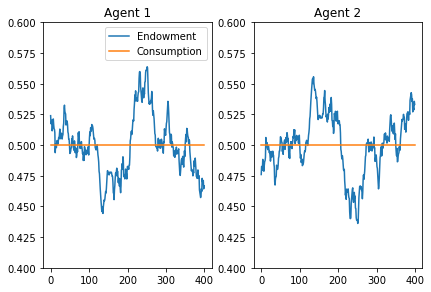

In [16]:
#Packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy.optimize import least_squares


#Parameters
theta=0.99 #endowments persistence
a=np.log(0.5)*(1-theta) #Calibrated to get exp(ln w) = exp(a/(1-theta))=0.5 = 
sigma=0.1 #shocks std. deviation
N=10000
beta=0.99 #discount factor
lambd=0.5
z=(1-lambd)/lambd #ratio of weights

"""Stochastic endowments"""
np.random.seed(10) #Reproducible simulation

#---- shocks -----
mean, cov = 0, sigma**2
shocks = np.random.normal(mean, cov, N)


#Endowments
w1=np.ones((N))*0.5
w2=np.ones((N))*0.5
for t in range(1,N):
    w1[t]=np.exp(a + theta*np.log(w1[t-1]) + shocks[t])
    w2[t]=1 - w1[t]


#Optimal consumption
c1=np.ones((N))
c2=np.ones((N))
for t in range(N):
    c1[t]= 1/(1+z)
    c2[t]= 1 - c1[t]


#Graph
fig, ax = plt.subplots(1, 2)
fig.tight_layout()
ax[0].plot(w1[400:800], label='Endowment')
ax[0].plot(c1[400:800], label='Consumption')
ax[0].set_title('Agent 1')
ax[0].set_ylim([0.4,0.6])
ax[0].legend()

ax[1].plot(w2[400:800])
ax[1].plot(c2[400:800])
ax[1].set_title('Agent 2')
ax[1].set_ylim([0.4,0.6])

### Would the full commitment solution violate a participation constraint?

As an intermediate step, compute the present value of both sharing and autarky implied by the previous setup. 

##### Autarky value
Define the autarky value
\begin{equation}
  V_t^i = \mathbb{E}_t \sum_{j=0}^\infty \beta^j ln(W_{t+j}^i)
\end{equation}

Given the endowment process, the present value of autarky for agent 1 boils down to (without most of the superindex, for convenience):

\begin{equation}
  V_t^1 = \mathbb{E}_t \sum_{j=0}^\infty \beta^j ln(W_{t+j})
  \\
  = \mathbb{E}_t \Big[ln W_t + \beta ln W_{t+1} + \beta^2 ln W_{t+2} + ...\Big]
  \\
  = \mathbb{E}_t \Big[ln W_t + \beta(a + \theta \text{ln} W_{t} + \epsilon_{t+1}) + \beta^2(a + \theta(a + \theta \text{ln} W_{t} + \epsilon_{t+1}) +\epsilon_{t+2})  + \beta^3(a+\theta(a + \theta(a + \theta \text{ln} W_{t} + \epsilon_{t+1}) +\epsilon_{t+2})+\epsilon_{t+3}) + ...\Big]
  \\
  = \beta a + \beta^2 a + \beta^3 a + ... + \beta^2\theta a + \beta^3 \theta a + \beta^3 \theta^2 a +   ... + ln W_t + \beta \theta ln W_t + (\beta\theta)^2 ln W_t  + (\beta\theta)^3 ln W_t + ...
  \\
  = a\sum_{j=1}^\infty \beta^j + a\beta\sum_{j=1}^\infty \beta^j \sum_{l=1}^j \theta^l + \sum_{j=0}^\infty (\beta \theta)^j ln W_t
  \\
  = \kappa + \frac{ln W_t}{1 - \beta\theta}
\end{equation}

with 
\begin{equation}
    \kappa = \frac{a\beta}{1 - \beta} + a\beta\sum_{j=1}^\infty \beta^j \sum_{l=1}^j \theta^l
 \end{equation}
 
 
 
 $V_t^2$ must follow a similar structure. However, it cannot be pinned down analytically. The reason is that
 \begin{equation}
 \mathbb{E}_t\Big[ln(W_{t+1}^2)\Big] = \mathbb{E}_t\Big[ln(1-W_{t+1}^1)\Big] = \mathbb{E}_t\Big[ln(1 - exp\{a + \theta ln(W_t^1) + \epsilon_{t+1}\})\Big] = ?
 \end{equation}
  is unknown. A reasonable alternative might be to compute the unknown $\tilde{a}$ and $\tilde{\theta}$ that characterizes $\{lnW_t^2\}$ using econometrics. Given the long horizon, running an AR(1) regression must deliver pretty accurate estimates. Then, we can recover $V_t^2$ too. 
 
 
 ##### Sharing value
 
 The value of being part of the social contract is given by
 \begin{equation}
       U_t^i = \mathbb{E}_t \sum_{j=0}^\infty \beta^j ln(C_{t+j}^i)
       \\
       = ln(\lambda^i) \sum_{j=0}^\infty \beta^j
       \\
       = \frac{ln(\lambda^i)}{1-\beta}
 \end{equation}
 

Text(0.5, 1.0, 'Agent 1 Welfare under different institutions')

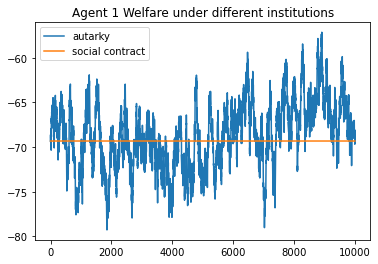

In [21]:
""" Autarky's value"""
#Analytical
#Compute kappa agent 1
ka=0
for n in range(1,N):
    for l in range(1,n):
        ka = ka + pow(beta,n)*pow(theta,l)
        
kappa=a*beta*(1/(1-beta) + ka)

V1=np.ones((N))
for t in range(N):
    V1[t]=kappa + np.log(w1[t])/(1-beta*theta)


""" Sharing's value
"""
U1=np.log(lambd)/(1-beta)

#Graph
plt.plot(V1, label='autarky')
plt.plot(np.ones((N))*U1, label='social contract')
plt.legend()
plt.title('Agent 1 Welfare under different institutions')

Check that it also holds for agent 2, under the econometric approach.

Text(0.5, 1.0, 'Agent 2')

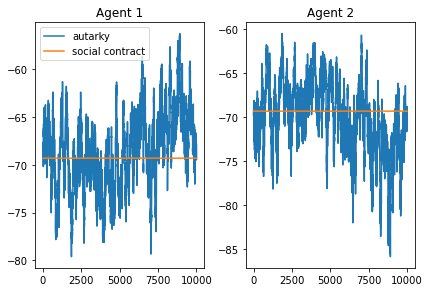

In [24]:
import statsmodels.api as sm

#Run an AR(1) regression for agent1
X=np.ones((N-1,2))
X[:,1]=np.log(w1[:-1])
est=sm.OLS(np.log(w1[1:]),X)
est = est.fit()
params1=est.params

#Compute kappa agent 1
kappa0=0
for n in range(1,N):
    for l in range(1,n):
        kappa0 = kappa0 + pow(beta,n)*pow(params1[1],l)
        
kappa1=params1[0]*beta*(1/(1-beta) + kappa0)

V11=np.ones((N))
for t in range(N):
    V11[t]=kappa1 + np.log(w1[t])/(1-beta*params1[1])
    
#Run an AR(1) regression for agent1
X=np.ones((N-1,2))
X[:,1]=np.log(w2[:-1])
est=sm.OLS(np.log(w2[1:]),X)
est = est.fit()
params2=est.params

#Compute kappa agent 2
kappa0=0
for n in range(1,N):
    for l in range(1,n):
        kappa0 = kappa0 + pow(beta,n)*pow(params2[1],l)
        
kappa2=params2[0]*beta*(1/(1-beta) + kappa0)

V2=np.ones((N))
for t in range(N):
    V2[t]=kappa2 + np.log(w2[t])/(1-beta*params2[1])

#Graph
fig, ax = plt.subplots(1, 2)
fig.tight_layout()
ax[0].plot(V11, label='autarky')
ax[0].plot(np.ones((N))*U1, label='social contract')
ax[0].set_title('Agent 1')
ax[0].legend()

ax[1].plot(V2)
ax[1].plot(np.ones((N))*U2)
ax[1].set_title('Agent 2')

Indeed, it can be checked that V1 (analytical) and V11 (econometrical) are almost identical (their mean difference mean(V1) - mean(V11) = -0.23). Hence, it seems the econometric approach to compute the autarky value might work.  

Result: indeed, the participation constraint would be violated many times. Then, full risk sharing would not survive agents self-determination (at least, period by period).


## Risk sharing with a participation constraint

Before agents would commit to never leave the risk-sharing arrangement. Instead, now they decide each period whether to stay or go, evaluating their outside option. 

A Pareto-optimal risk-sharing contract with PC can be found by solving the following problem: 

\begin{equation}
      \max_{\substack{\{C_t^1, C_t^2\}_{t=0}^\infty}} \mathbb{E}_0 \sum_{t=0}^\infty \delta^t \lambda ln(C_t^1) + (1-\lambda) ln(C_t^2)
\end{equation}
s.t. 
Feasibility: 
\begin{equation}
    C_t^1 + C_t^2 = 1
\end{equation}

Participation constraint for i=1,2:
\begin{equation}
  \mathbb{E}_t \sum_{j=0}^\infty \beta^j ln(C_{t+j}^i) \geq V_t^i
\end{equation}

with the outside option being
\begin{equation}
  V_t^i = \mathbb{E}_t \sum_{j=0}^\infty \beta^j ln(W_{t+j}^i)
\end{equation}

Using the Marcet and Marimon (2019)'s approach, the Lagrangean of the previous problem can be recast in a recursive way:
\begin{equation}
 \mathcal{L} = \mathbb{E}_0 \sum_{t=0}^\infty \delta^t (\lambda + \mu_t^1) ln(C_t^1) + (1-\lambda + \mu_t^2) ln(C_t^2)
\end{equation}
s.t. 
\begin{equation}
    \mu_t^i = \mu_{t-1}^i + \gamma_t^i
\end{equation}
with $\mu_{-1}=0$ and $\gamma_t^i \geq 0$ for i=1,2. 

In this case, the co-state variable $\mu$ captures the value of past commitments. 


##### Equilibrium conditions

i) Feasibility: 
\begin{equation}
    C_t^1 + C_t^2 = 1
\end{equation}

ii) Risk-sharing:
\begin{equation}
    \frac{C_t^2}{C_t^1} = \frac{1-\lambda + \mu_t^2}{\lambda + \mu_t^1}
\end{equation}

iii) Slackness of the participation constraint (for i=1,2):
\begin{equation}
    \gamma_t^i\Bigg(ln(C_t^i) + \beta \mathbb{E}_t \sum_{j=0}^\infty \beta^j ln(C_{t+1+j}^i) - V_t^i\Bigg)=0
\end{equation}
with $\gamma_t^i \geq 0$. 

iv) Commitment updating (for i=1,2):
\begin{equation}
   \mu_t^i = \mu_{t-1}^i + \gamma_t^i 
\end{equation}


#### Algorithm to solve and simulate the model

1.- Simulate a long series of shocks $\{\epsilon_t^i\}_{t=0}^T$ for i=1,2. Get the endowments $\{W_t^i\}_{t=0}^T$ for i=1,2. 

2.- Guess some values for the parameters $\eta$. 

3.- Solve for equilibrium consumption presuming no agent is constrained (that is,  assuming $\mu_t^i = \mu_{t-1}^i$ for all i). Then, risk-sharing and feasibility conditions deliver $(\bar{C_t^1}, \bar{C_t^2})$.


4.- Check the Participation Constraint. 

  4.1.- Compute the outside option's value. The chosen process implies 
    \begin{equation}
         V_t^i = \kappa + \frac{ln W_t^i}{1 - \beta\theta}
    \end{equation}
   
   4.2.- Parameterize the expected discounted sum of future utility of participation: 
    \begin{equation}
            ln(C_t^i) + \beta \mathbb{E}_t \sum_{l=0}^\infty \beta^l ln(C_{t+1+l}^i)  = ln(C_t^i) + \beta \psi({x_t}; {\eta}^i)
    \end{equation}
  where ${x_t} = \{W_t^1, Z_t\}$ are the states at time t and $\eta$ a vector of parameters. $Z_t = \frac{1-\lambda + \mu_{t-1}^2}{\lambda + \mu_{t-1}^1}$ is the ratio of weights at the beginning of the period.  
  
  
  4.3.- Check the constraint. There are 3 cases:
  
  **Case 1**: None of the PC is binding. Then, $(\bar{C_t^1}, \bar{C_t^2}) = ((C_t^1)^*, (C_t^2)^*)$.
  
  **Case 2**: $PC^i$ is binding, $PC^j$ is not. In this case, 
  
  i) Recover $(C_t^i)^*$ from $PC^i$:
  \begin{equation}
        (C_t^i)^* = exp\Big\{V_t^i - \beta \psi({x_t}; {\eta})\Big\}
  \end{equation}
  
  ii) Recover $(C_t^j)^*$ from feasibility:
  \begin{equation}
      (C_t^j)^* = W_t^i + W_t^j - (C_t^i)^*
  \end{equation}
  
  iii) Since $PC^j$ is not binding, $\gamma_t^j = 0$ and $\mu_t^j = \mu_{t-1}^j$. 
  
  iv) Recover $\mu_t^i$ from the optimal risk-sharing condition: 
  \begin{equation}
        \mu_t^i = (C_t^i)^* \Big(\frac{\lambda^j + \mu_t^j}{(C_t^j)^* }\Big) - \lambda^i 
   \end{equation}
   with $\lambda^1 = \lambda$ and $\lambda^2 = 1- \lambda$. 
   
   
   **Case 3**: Both PCs are binding. Cannot happen (it's a zero sum game). 
   

5.- Get the right $\eta$ using PEA. 

5.1.- Compute a non-linear regression:
    \begin{equation*}
        G(\eta) = \underset{\nu \in \mathbb{R}^n}{\operatorname{argmin}} \sum_{i=1,2} \frac{1}{(T-\underline{T})}\sum_{t=\underline{T}}^{T}\Bigg[\sum_{l=0}^M \beta^l ln(C_{t+l+1}(\eta)^i)- \psi\Big(x_t(\eta); \nu\Big)\Bigg]^2
      \end{equation*}
  
 5.2.- Update the coefficients:
 \begin{equation*}
        \eta ^{s+1} = \eta^s + d(G(\eta^s) - \eta^s)
        \end{equation*}
    and redo 3 to 5.1. until reaching a fixed point $\eta_f =  G(\eta_f)$. 
    
    
    
 ### About the approximating function
 
 What is a convenient choice for $\psi$? Its form is known for two limit cases. 

Under **full risk sharing**:
  \begin{equation}
       U_t^1 = ln(C_t^1) + \beta U_{t+1}^1
       = \frac{ln(1/(1+Z))}{1-\beta}
 \end{equation}
 Hence, 
 \begin{equation}
      (U_{t+1}^1)^s = \psi_s(\cdot) = \frac{1}{(1-\beta)}ln(1/(1+Z))
 \end{equation}
 
 where $Z = (1-\lambda)/\lambda$. 
 
 Under **autarky**:
 \begin{equation}
  U_t^1 = ln(C_t^1) + \beta U_{t+1}^1
       = \frac{ln(1/(1+Z))}{1-\beta} = V_t^1 =  \kappa + \frac{ln W_t^1}{1 - \beta\theta}
 \end{equation}
 Hence,
  \begin{equation}
      (U_{t+1}^1)^a = \psi_a(\cdot) = \frac{\kappa}{\beta} + \frac{\theta}{(1-\theta\beta)}ln W_t^1
 \end{equation}
 
 It is clear that a function of this form
 \begin{equation}
       \psi_1(Z_t, W_t; \eta^1) = \eta_0^1 + \eta_1^1 ln(1/(1+Z_t)) + \eta_2^1 ln W_t^1
 \end{equation}
 encompases both cases and then, it seems a reasonable candidate for a solution.
 
 Simulate the model for a given $\eta$.

In [55]:
#Packages
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.optimize as optimize
from scipy.optimize import least_squares
import warnings
warnings.filterwarnings('ignore')

#Parameters
theta=0.99 #endowments persistence
a=np.log(0.5)*(1-theta) #Calibrated to get exp(ln w) = exp(a/(1-theta))=0.5 = 
sigma=0.1 #shocks std. deviation
N=10000
beta=0.99 #discount factor
lambd=0.5
z=(1-lambd)/lambd #ratio of weights
weight1=lambd
Initial=100
Horizon=2000

"""Stochastic endowments"""
np.random.seed(10) #Reproducible simulation

#---- shocks -----
mean, cov = 0, sigma**2
shocks = np.random.normal(mean, cov, N)


#Endowments
w1=np.ones((N))*0.5
w2=np.ones((N))*0.5
for t in range(1,N):
    w1[t]=np.exp(a + theta*np.log(w1[t-1]) + shocks[t])
    w2[t]=1 - w1[t]



""" Autarky's value"""
#Run an AR(1) regression for agent1
X=np.ones((N-1,2))
X[:,1]=np.log(w1[:-1])
est=sm.OLS(np.log(w1[1:]),X)
est = est.fit()
params1=est.params

#Compute kappa agent 1
kappa0=0
for n in range(1,N):
    for l in range(1,n):
        kappa0 = kappa0 + pow(beta,n)*pow(params1[1],l)
        
kappa1=params1[0]*beta*(1/(1-beta) + kappa0)

V1=np.ones((N))
for t in range(N):
    V1[t]=kappa1 + np.log(w1[t])/(1-beta*params1[1])
    
#Run an AR(1) regression for agent1
X=np.ones((N-1,2))
X[:,1]=np.log(w2[:-1])
est=sm.OLS(np.log(w2[1:]),X)
est = est.fit()
params2=est.params

#Compute kappa agent 2
kappa0=0
for n in range(1,N):
    for l in range(1,n):
        kappa0 = kappa0 + pow(beta,n)*pow(params2[1],l)
        
kappa2=params2[0]*beta*(1/(1-beta) + kappa0)

V2=np.ones((N))
for t in range(N):
    V2[t]=kappa2 + np.log(w2[t])/(1-beta*params2[1])

""" Parameterized Expectations """
def poly1(eta0, eta1,eta2, z, w):
    return eta0 + eta1*np.log(1/(1+z)) + eta2*np.log(w)

def poly2(eta0, eta1,eta2, z, w):
    return eta0 + eta1*np.log(1/(1+(1/z))) + eta2*np.log(1-w)

par=0.995
etas=np.zeros((6))
etas[0]=par*kappa1/beta
etas[1]=(1-par)/(1-beta)
etas[2]=par*params1[1]/(1-beta*params1[1])
etas[3]=par*kappa2/beta
etas[4]=(1-par)/(1-beta)
etas[5]=par*params2[1]/(1-beta*params2[1])
   
""" Simulation"""
eta01=etas[0]
eta11=etas[1]
eta21=etas[2]
eta02=etas[3]
eta12=etas[4]
eta22=etas[5]

mu1=np.zeros((N))
mu2=np.zeros((N))
C1=np.zeros((N))
C2=np.zeros((N))
C1_pre=np.zeros((N))
C2_pre=np.zeros((N))
U1=np.zeros((N))
U2=np.zeros((N))
count1=np.zeros((N))
count21=np.zeros((N))
count211=np.zeros((N))
count22=np.zeros((N))
count221=np.zeros((N))
count3=np.zeros((N))
z=np.zeros((N))

for t in range(1,N):
    C1_pre[t]=(weight1 + mu1[t-1])/(mu1[t-1] + mu2[t-1] + 1)
    C2_pre[t]=1-C1_pre[t]

    mu1[t]=mu1[t-1]
    mu2[t]=mu2[t-2]

    #------------- Check the Participation constraint
    #Expected utility of participating
    z[t]=(1-weight1+mu2[t-1])/(weight1 + mu1[t-1])
    U1[t]=np.log(C1_pre[t]) + beta*poly1(eta01, eta11, eta21,  z[t], w1[t])
    U2[t]=np.log(C2_pre[t]) + beta*poly2(eta02, eta12, eta22,  z[t], w1[t])



    #Case 1: None binding.
    if U1[t]>=V1[t] and U2[t]>=V2[t]:
        C1[t]=C1_pre[t]
        C2[t]=C2_pre[t]
        count1[t]=1

        
    #Case 2.1: PC1 is binding; PC2 is not
    elif U1[t]<V1[t] and U2[t]>V2[t]:
        C1[t]=np.exp(V1[t]-beta*poly1(eta01, eta11, eta21, z[t], w1[t]))
        C2[t]=1-C1[t]
        mu2[t]=mu2[t-1]
        mu1[t]=(C1[t]*(1-weight1 + mu2[t])/C2[t])-weight1
        count21[t]=1

        #Check PC2
        U2[t]=np.log(C2[t]) + beta*poly2(eta02, eta12, eta22,  z[t], w1[t])
        if U2[t]<V2[t]:
            C2[t]=np.exp(V2[t]-beta*poly2(eta02, eta12, eta22, z[t], w1[t]))
            mu2[t]=(C2[t]*(weight1 + mu1[t])/C1[t])- (1-weight1)
            count211[t]=1
        
        
    #Case 2.2: PC2 is binding; PC1 is not
    elif U2[t]<V2[t] and U1[t]>V1[t]:
        C2[t]=np.exp(V2[t]-beta*poly2(eta02, eta12, eta22, z[t], w1[t]))
        C1[t]=1 -C2[t]
        mu1[t]=mu1[t-1]
        mu2[t]=(C2[t]*(weight1 + mu1[t])/C1[t])- (1-weight1)
        count22[t]=1

        #Check PC1
        U1[t]=np.log(C1[t]) + beta*poly1(eta01, eta11, eta21,  z[t], w1[t])
        if U1[t]<V1[t]:
            C1[t]=np.exp(V1[t]-beta*poly1(eta01, eta11, eta21, z[t], w1[t]))                
            mu1[t]=(C1[t]*(1-weight1 + mu2[t])/C2[t])-weight1
            count221[t]=1


    #Case 3: Both binding
    else:
        C1[t]=np.exp(V1[t]-beta*poly1(eta01, eta11, eta21, z[t], w1[t]))
        C2[t]=np.exp(V2[t]-beta*poly2(eta02, eta12, eta22, z[t], w1[t]))
        #C2[t]=1-C1[t]

        #Update multipliers (arbitrary, just for the algorithm to work. In equilibrium, it shouldn't visit this region)
        x1=(U1[t]-V1[t])/10
        x2=(U2[t]-V2[t])/10
        mu1[t]=mu1[t-1]+x1
        mu2[t]=mu2[t-1]+x2
        count3[t]=1


    #update sharing value
    U1[t]=np.log(C1[t]) + beta*poly1(eta01, eta11, eta21,  z[t], w1[t])
    U2[t]=np.log(C2[t]) + beta*poly2(eta02, eta12, eta22,  z[t], w1[t])



"""                           Approximation errors              """ 
error1=np.ones((N))   
error2=np.ones((N))  
lhs1=np.zeros((N))   
rhs1=np.zeros((N))
lhs2=np.zeros((N))
rhs2=np.zeros((N))   


for t in range(N-Horizon):
    #agent 1
    for j in range(Horizon):
        rhs1[t]=rhs1[t] + pow(beta,j)*np.log(C1[t+j+1])

    lhs1[t]=poly1(eta01, eta11, eta21, z[t], w1[t])
    error1[t]=pow(lhs1[t]-rhs1[t],2)

    #agent 2 
    for j in range(Horizon):
        rhs2[t]=rhs2[t] + pow(beta,j)*np.log(C2[t+j+1])

    lhs2[t]=poly2(eta02, eta12, eta22, z[t], w1[t])
    error2[t]=pow(lhs2[t]-rhs2[t],2)

ssr=np.nanmean(error1[Initial:-Horizon]) + np.nanmean(error2[Initial:-Horizon])

Visualize some of the simulated time series. 

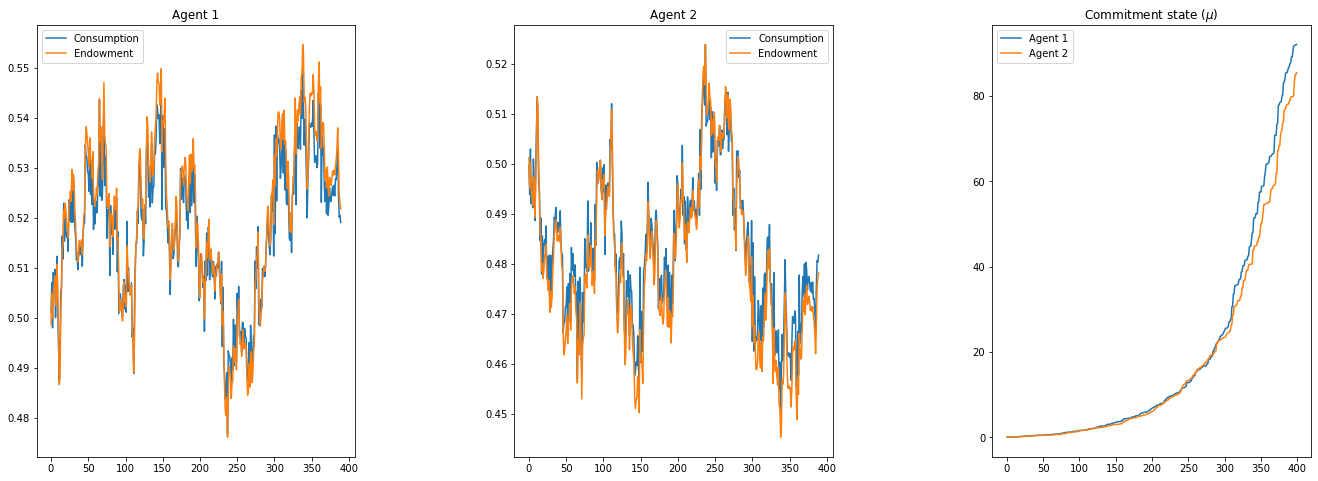

In [56]:
#Graph
fig, ax = plt.subplots(1, 3)
plt.subplots_adjust(left=0.05, bottom=0.0, right=3, top=1.5, wspace=0.5, hspace=0.25)


#fig.tight_layout()
ax[0].plot(C1[10:400], label='Consumption')
ax[0].plot(w1[10:400], label='Endowment')
ax[0].set_title('Agent 1')
ax[0].legend()

ax[1].plot(C2[10:400], label='Consumption')
ax[1].plot(w2[10:400], label='Endowment')
ax[1].set_title('Agent 2')
ax[1].legend()

ax[2].plot(mu1[0:400], label='Agent 1')
ax[2].plot(mu2[0:400], label='Agent 2')
ax[2].set_title('Commitment state ($\mu$)')
ax[2].legend()

#### Check constraints and errors

In [61]:
clearing=np.zeros((N))
pc1=np.zeros((N))
pc2=np.zeros((N))
sharing=np.zeros((N))
viol1=np.zeros((N))
viol2=np.zeros((N))

for t in range(N):
    clearing[t]=C1[t] + C2[t] - 1
    pc1[t]=U1[t]-V1[t]
    if pc1[t]<0:
        viol1[t]=1
    pc2[t]=U2[t]-V2[t]
    if pc2[t]<0:
        viol2[t]=1
    sharing[t]=C2[t]/C1[t] - (1-lambd + mu2[t])/(lambd + mu1[t])
    
print('Average excess demand: %1.4f'% (np.mean(clearing[100:-100])))  
print('Average slack PC1: %1.4f'%(np.mean(pc1[100:-100])))
print('Number of violations PC1 %1.4f'%(np.sum(viol1[100:-100])))
print('Average slack PC2: %1.4f'%(np.mean(pc2[100:-100])))
print('Number of violations PC2 %1.4f'%( np.sum(viol2[100:-100])))
print('Average slack sharing: %1.4f'%(np.mean(sharing[100:-100])))
print('Sum Square Residuals %1.4f'%(ssr))
print('This is an example of a small deviation from autarky that makes agents better off.')

Average excess demand: 0.0006
Average slack PC1: 0.0002
Number of violations PC1 0.0000
Average slack PC2: 0.0002
Number of violations PC2 0.0000
Average slack sharing: 0.0001
Sum Square Residuals 19.2243
This is an example of a small deviation from autarky that makes agents better off.


In [60]:
np.mean(count22)

0.4787